# Assignment 5: Link Analysis

In this assignment, we will use network-based algorithms, such as PageRank, to improve our search results. After the last assignment on evaluating IR systems, we go back to our PubMed dataset of scientific papers. In this dataset, we look at two graphs in particular: the co-authorship network and the citation network.

The citation network is similar to the link network of the web: Citations are like web links pointing to other documents. We can therefore apply the same network-based ranking methods.

## Code from previous assignments

In [1]:
import pickle, bz2
from collections import defaultdict, namedtuple, Counter
from math import log10, sqrt
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# show plots inline within the notebook
%matplotlib inline
# set plots' resolution
plt.rcParams['savefig.dpi'] = 100

In [2]:
Ids_file = 'data/cognition_Ids.pkl.bz2'
Summaries_file = 'data/cognition_Summaries.pkl.bz2'
Citations_file = 'data/cognition_Citations.pkl.bz2'
Abstracts_file = 'data/cognition_Abstracts.pkl.bz2'

Ids = pickle.load( bz2.BZ2File( Ids_file, 'rb' ) )
Summaries = pickle.load( bz2.BZ2File( Summaries_file, 'rb' ) )
Citations = pickle.load( bz2.BZ2File( Citations_file, 'rb' ) )
Abstracts = pickle.load( bz2.BZ2File( Abstracts_file, 'rb' ) )

paper = namedtuple( 'paper', ['title', 'authors', 'year', 'doi'] )

for (id, paper_info) in Summaries.items():
    Summaries[id] = paper( *paper_info )

In [3]:
def display_summary( id, show_abstract=False, show_id=True, extra_text='' ):
    """
    Function for printing a paper's summary through IPython's Rich Display System.
    Trims long author lists, and adds a link to the paper's DOI (when available).
    """
    s = Summaries[id]
    lines = []
    title = s.title
    
    if s.doi != '':
        title = '<a href=http://dx.doi.org/{:s}>{:s}</a>'.format(s.doi, title)
    title = '<strong>' + title + '</strong>'
    lines.append(title)
    authors = ', '.join( s.authors[:20] ) + ('' if len(s.authors) <= 20 else ', ...')
    lines.append(str(s.year) + '. ' + authors)
    if (show_abstract):
        lines.append('<small><strong>Abstract:</strong> <em>{:s}</em></small>'.format(Abstracts[id]))
    if (show_id):
        lines.append('[ID: {:d}]'.format(id))
    if (extra_text != ''):
         lines.append(extra_text)
    display( HTML('<br>'.join(lines)) )



In [4]:
def tokenize(text):
    return text.split(' ')

def preprocess(tokens):
    result = []
    for token in tokens:
        result.append(token.lower())
    return result

In [5]:
inverted_index = defaultdict(list)

for id in sorted(Summaries.keys()):
    term_set = set(preprocess(tokenize(Summaries[id].title)))
    if id in Abstracts:
        term_set.update(preprocess(tokenize(Abstracts[id])))
    for term in term_set:
        inverted_index[term].append(id)

tf_matrix = defaultdict(Counter)

for doc_id in Summaries.keys():
    tokens = preprocess(tokenize(Summaries[doc_id].title))
    if (doc_id in Abstracts):
        tokens.extend(preprocess(tokenize(Abstracts[doc_id])))
    tf_matrix[doc_id] = Counter(tokens)

def tf(t,d):
    return float(tf_matrix[d][t])

def df(t):
    return float(len(inverted_index[t]))

num_documents = float(len(Summaries))

def idf(t):
    return log10((num_documents + 1)/(df(t) + 1))

def tfidf(t,d):
    return tf(t,d) * idf(t)

## Co-authorship network

We start by building a mapping from authors to the set of identifiers of papers they authored.  We'll be using Python sets again for that purpose.

In [6]:
papers_of_author = defaultdict(set)

for (id, p) in Summaries.items():
    for a in p.authors:
        papers_of_author[a].add(id)

Let's try it out:

In [7]:
papers_of_author['Jensen C']

{26860092, 26973573, 31649584, 33190365, 33471320}

In [8]:
for id in papers_of_author['Jensen C']:
    display_summary(id)

We can now build a co-authorship network, that is a graph linking authors to the set of co-authors they have published with:

In [9]:
coauthors = defaultdict(set)

for p in Summaries.values():
    for a in p.authors:
        coauthors[a].update(p.authors)

# The code above results in each author being listed as having co-authored with himself/herself.
# We remove these self-references here:
for (a, ca) in coauthors.items():
    ca.remove(a)

And let's try it out again:

In [10]:
print(', '.join( coauthors['Jensen C'] ))

Johansen T, Dittrich WH, Forlini C, Lyby PS, Del Risco Kollerud R, Holsen IN, Marlow T, Nelson M, Rabiei K, Øyeflaten I, Lenton S, Holsen I, Eriksen HR, Jakobsen H, Jaraj D, Partridge B, Skoog I, Wikkelsø C, Hall W


Unlike a citation or link network, the edges of this co-authorship network are not directed: There is no direction (no arrow) in the link between author 'Jensen C' and 'Holsen IN', for example. With our chosen implementation, each of these links in fact appears twice in our data, as we also get 'Jensen C' as co-author when we look for 'Holsen IN':

In [11]:
print(', '.join( coauthors['Holsen IN'] ))

Johansen T, Dittrich WH, Jensen C, Eriksen HR, Jakobsen H, Øyeflaten I, Lyby PS


With that in mind, we can calculate some basic statistics about our graph:

In [12]:
print('Number of nodes (authors): ', len(coauthors))

# We divide by two here to account for the fact that each edge is represented twice (see above):
coauthor_rel_count = int(sum( len(c) for c in coauthors.values() ) / 2)
print('Number of links (co-authorship relations): ', coauthor_rel_count)

Number of nodes (authors):  232358
Number of links (co-authorship relations):  1999606


With this data at hand, we can plot the [degree distribution](https://en.wikipedia.org/wiki/Degree_distribution) by showing the number of collaborators a scientist has published with:

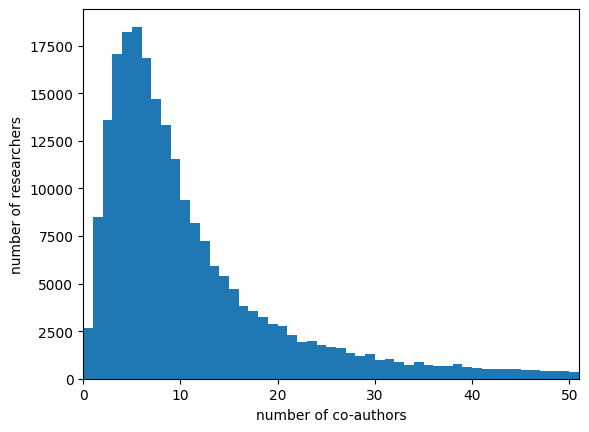

In [13]:
plt.hist( x=[ len(ca) for ca in coauthors.values() ], bins=range(60) )
plt.xlabel('number of co-authors')
plt.ylabel('number of researchers')
plt.xlim(0,51);

Now that we have explored this network, let's move to the citation network.

## Citations network

Next, we can look at the citation network. In contrast to the co-authorship network, the citation network is a _directed_ network, where edges can be drawn as arrows. We'll start by expanding the our data about citations into two mappings: 

* `papers_citing[id]`: papers citing a given paper
* `cited_by[id]`: papers cited by a given paper (in other words: its list of references)

`papers_citing` will give us the list of a node's incoming links, whereas `cited_by` will give us the list of its outgoing links.

In [14]:
papers_citing = Citations  # no changes needed, this is what we are storing already in the Citations dataset

cited_by = defaultdict(list)

for ref, papers_citing_ref in papers_citing.items():
    for id in papers_citing_ref:
        cited_by[ id ].append( ref )

As we are dealing with a subset of the data (the papers mentioning "cognition"), `papers_citing` can contain references to papers outside of our subset. On the other hand, the way we created `cited_by`, it will only contain backward references from within our dataset, meaning that it is incomplete with respect to the whole dataset. Nethertheless, we can use this citation network on our subset of emotion-related papers to implement link analysis techniques.

Let us now look at an exemplary paper, let's say the one with identifier 26784347. We can now use the `cited_by` mapping to retrieve its (incomplete) list of references:

In [15]:
paper_id = 26973573
refs = { id : Summaries[id].title for id in cited_by[paper_id] }
print(len(refs), 'references found for paper', paper_id)
refs

2 references found for paper 26973573


{24606831: 'Life context of pharmacological academic performance enhancement among university students--a qualitative approach.',
 23486311: 'Just How Cognitive Is "Cognitive Enhancement"? On the Significance of Emotions in University Students\' Experiences with Study Drugs.'}

If we lookup the same paper in `papers_citing`, we now see that some of the cited papers are themselves in our dataset, but others are not (shown below as `'??'`):

In [16]:
{ id : Summaries.get(id,['??'])[0]  for id in papers_citing[paper_id] }

{35742024: '??',
 35478516: '??',
 35081158: '??',
 34964411: '??',
 34485541: '??',
 33897499: '??',
 33802176: '??',
 31934382: '??',
 31554263: '??',
 31391711: 'Developing expertise, customising sleep, enhancing study practices: exploring the legitimisation of modafinil use within the accounts of UK undergraduate students.',
 31143791: '??',
 30681970: '??',
 30453936: '??',
 29904327: '??',
 28554200: 'The Memory-Enhancing Effects of Liquiritigenin by Activation of NMDA Receptors and the CREB Signaling Pathway in Mice.'}

Paper 35742024, for example, is not in our dataset and we do not have any direct information about it, but its repeated occurrence in other papers' citation lists does allow us to reconstruct some of its references. Below is the list of papers in our dataset cited by that paper:

In [17]:
paper_id2 = 35742024
refs2 = { id : Summaries[id].title for id in cited_by[paper_id2] }
print(len(refs2), 'references identified for the paper with id', paper_id2)
refs2

6 references identified for the paper with id 35742024


{35206801: 'Can Nutrients and Dietary Supplements Potentially Improve Cognitive Performance Also in Esports?',
 31101387: 'The influence of environmental pressure on Internet Use Disorder in adolescents: The potential mediating role of cognitive function.',
 27706797: 'Repurposing Drugs for Cognition in Schizophrenia.',
 26973573: "Australian University Students' Coping Strategies and Use of Pharmaceutical Stimulants as Cognitive Enhancers.",
 19300592: "Potential cognitive enhancing and disease modification effects of SSRIs for Alzheimer's disease.",
 15330974: 'Cognition-enhancing drugs.'}

Now that we have a better understanding about the data we're dealing with, let us obtain again some basic statistics about our graph.

In [18]:
n = len(Ids)
print('Number of papers in our subset: {:d} ({:.2f} %)'.format(n, 100.0) )

with_citation = [ id for id in Ids if papers_citing[id] != [] ]
with_citation_rel = 100. * len(with_citation) / n
print('Number of papers cited at least once: {:d} ({:.2f} %)'.format(len(with_citation), with_citation_rel) )

isolated = set( id for id in Ids if papers_citing[id] == [] and id not in cited_by )
isolated_rel = 100. * len(isolated) / n
print('Number of isolated nodes:  {:d} ({:.2f} %)'.format(len(isolated), isolated_rel) )

Number of papers in our subset: 102128 (100.00 %)
Number of papers cited at least once: 82163 (80.45 %)
Number of isolated nodes:  14342 (14.04 %)


In [19]:
id_set = set( Ids )
citing_set = set( cited_by.keys() )

outsiders = citing_set - id_set   # set difference
nodes = citing_set | id_set   # set union
non_isolated = nodes - isolated   # set difference

print('Overall number of nodes: {:d} ({:.2f} %)'.format(len(nodes), 100.0) )

non_isolated_rel = 100. * len(non_isolated) / len(nodes)
print('Number of non-isolated nodes: {:d} ({:.2f} %)'.format(len(non_isolated), non_isolated_rel) )

outsiders_rel = 100. * len(outsiders) / len(nodes)
print('Number of nodes outside our subset: {:d} ({:.2f} %)'.format( len(outsiders), outsiders_rel ) )

Overall number of nodes: 591542 (100.00 %)
Number of non-isolated nodes: 577200 (97.58 %)
Number of nodes outside our subset: 489414 (82.74 %)


In [20]:
all_citations = [ c for citing in papers_citing.values() for c in citing ]
outsider_citations = [ c for citing in papers_citing.values() for c in citing if c in outsiders ]

print('Overall number of links (citations): {:d} ({:.2f} %)'.format(len(all_citations), 100.0) )

outsider_citations_rel = 100. * len(outsider_citations) / len(all_citations)
print('Citations outside the subset: {:d} ({:.2f} %)'.format(len(outsider_citations), outsider_citations_rel) )

Overall number of links (citations): 1481661 (100.00 %)
Citations outside the subset: 1215358 (82.03 %)


Let us now find our which 10 papers are the most cited in our dataset.

In [21]:
citation_count_per_paper = [ (id, len(citations)) for (id,citations) in papers_citing.items() ]
sorted_by_citation_count = sorted(citation_count_per_paper, key=lambda i:i[1], reverse=True)

for (id, c) in sorted_by_citation_count[:10]:
    display_summary(id, extra_text = 'Citation count: ' + str(c))

Before we can start calculating some interesting network metrics, we will first have a closer look at the Python package that we are going to use for that.

## Link Analysis for Search Engines

In order to use the citation network, we need to be able to perform some complex graph algorithms on it. To make our lives easier, we will use [NetworkX](https://pypi.python.org/pypi/networkx), a Python package for dealing with complex networks:

In [22]:
! pip3 install --user networkx

In [23]:
import networkx as nx

G = nx.DiGraph(cited_by)

We now have a NetworkX Directed Graph stored in `G`, where a node represents a paper, and an edge represents a citation. This means we can now apply the [algorithms](http://networkx.github.io/documentation/networkx-1.10/reference/algorithms.html) and [functions](http://networkx.github.io/documentation/networkx-1.10/reference/functions.html) of NetworkX to our graph:

In [24]:
print(nx.info(G))
print('Directed graph:', nx.is_directed(G))
print('Density of graph:', nx.density(G))

/var/folders/gm/j6b9d4fx06q0g89jjy_7y21w0000gn/T/ipykernel_81036/1622351100.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


DiGraph with 577200 nodes and 1481661 edges
Directed graph: True
Density of graph: 4.447305434486632e-06


As this graph was generated from citations only, we need to add all isolated nodes (nodes that are not cited and do not cite other papers) as well:

In [25]:
G.add_nodes_from(isolated)

And now we get slightly different values:

In [26]:
print(nx.info(G))
print('Directed graph:', nx.is_directed(G))
print('Density of graph:', nx.density(G))

/var/folders/gm/j6b9d4fx06q0g89jjy_7y21w0000gn/T/ipykernel_81036/1622351100.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


DiGraph with 591542 nodes and 1481661 edges
Directed graph: True
Density of graph: 4.2342686892270706e-06


Now we are ready to use this package for our tasks.

----------

# Tasks

**Your name:** Ryan Ott

### Task 1

Plot the in-degree distribution (that is, the distribution of the number of incoming links; see [here](https://en.wikipedia.org/wiki/Degree_distribution) and [here](http://mathinsight.org/degree_distribution) for more detailed explanations) for the citation network. What can you tell about the shape of this distribution, and what does this tell us about the network?

**Answer:** 


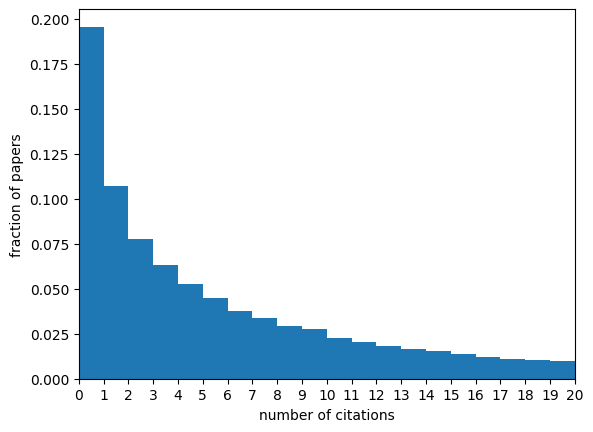

In [27]:
citations_per_paper = [ len(citations) for (_,citations) in papers_citing.items() ]
plt.hist(x=citations_per_paper, bins=range(min(citations_per_paper), max(citations_per_paper)+1), density=True)
plt.xlabel('number of citations')
plt.ylabel('fraction of papers')
plt.xticks(range(0, 21, 1))
plt.xlim(0,20);

### Task 2

Using the [Link Analysis](https://networkx.org/documentation/stable/reference/algorithms/link_analysis.html) algorithms provided by NetworkX, calculate the PageRank score for all nodes in the citation network, and store the result in a variable called `pageranks`.

To test this, create first a list of all papers that are cited by exactly 10 other papers (using `papers_citing` defined above). Then sort these papers by their PageRank and retrieve the paper IDs with the maximum and minimum PageRank values. Print these minimum and maximum PageRank values together with their paper IDs.

To print PageRank values, you might want to use commands like `print('{:.6f}'.format(var))` to use regular decimal notation with a fixed number of decimal places.

In [28]:
pageranks = nx.pagerank(G)

papers_cited_10_times = [id for id in Ids if len(papers_citing[id]) == 10]
papers_cited_10_times.sort(key=lambda id: pageranks[id], reverse=True)
best_pr = papers_cited_10_times[0]
worst_pr = papers_cited_10_times[-1]
print(f"Highest ranked paper cited 10 times: {best_pr} - PageRank: {pageranks[best_pr]:.6f}")
print(f"Lowest ranked paper cited 10 times: {worst_pr} - PageRank: {pageranks[worst_pr]:.6f}")

Highest ranked paper cited 10 times: 9236629 - PageRank: 0.000057
Lowest ranked paper cited 10 times: 23379271 - PageRank: 0.000001


### Task 3

Why do the two papers above have such different PageRank values? Write code below to investigate and show the cause of this, and then explain the cause of this difference based on the results generated by your code.

In [29]:
def print_node_info(id):
    print("Info about paper", id)
    total_score = 0
    for i, paper in enumerate(papers_citing[id], 1):
        pr = pageranks[paper]
        outlink_count = len(cited_by[paper])
        score = pr/outlink_count
        total_score += score
        print(f"{i}: {paper} - PR: {pr:.6f} - # of out-links: {outlink_count} => Add: {score:.7f}")
    print(f"Total score: {total_score:.7f}")
    print("-----------------------------------")

print_node_info(best_pr)
print_node_info(worst_pr)

Info about paper 9236629
1: 33308067 - PR: 0.000001 - # of out-links: 4 => Add: 0.0000002
2: 29684402 - PR: 0.000002 - # of out-links: 36 => Add: 0.0000001
3: 28588527 - PR: 0.000001 - # of out-links: 4 => Add: 0.0000002
4: 26839123 - PR: 0.000001 - # of out-links: 1 => Add: 0.0000007
5: 25180980 - PR: 0.000001 - # of out-links: 4 => Add: 0.0000002
6: 23874416 - PR: 0.000001 - # of out-links: 2 => Add: 0.0000004
7: 22586384 - PR: 0.000001 - # of out-links: 5 => Add: 0.0000001
8: 18990119 - PR: 0.000001 - # of out-links: 9 => Add: 0.0000001
9: 17500630 - PR: 0.000122 - # of out-links: 2 => Add: 0.0000609
10: 10466154 - PR: 0.000001 - # of out-links: 3 => Add: 0.0000002
Total score: 0.0000631
-----------------------------------
Info about paper 23379271
1: 35422471 - PR: 0.000001 - # of out-links: 13 => Add: 0.0000001
2: 34281109 - PR: 0.000001 - # of out-links: 28 => Add: 0.0000000
3: 34188592 - PR: 0.000001 - # of out-links: 12 => Add: 0.0000001
4: 33897481 - PR: 0.000001 - # of out-li

**Explanation:** PageRank is a measure of the importance of a node/document/page based on the sum of values of incomming edges/citations/links (+ the random surfer model). The value of an incoming link to page a is the PageRank of the page b from where the link is coming over the number of outgoing links from page b.
We can therefore understand the difference in PageRank of our two papers by looking at the PageRanks of documents linking to our papers and the number of links outgoing from each paper linking.

Above code shows this, for the high PageRank paper 9236629, we have a bunch of low PageRank papers linking to it but paper 17500630 has a very high value and more importantly only has two outgoing links. This indicates that this highly valueable paper felt that 9236629 was so important that it had to be one of the only two outgoing links (citations). This gives 9236629 a high PageRank.

Low PageRank paper 23379271 on the other hand has no valuable paper citing it, moreover the papers that do cite it tend to have a lot of outgoing citations, dilluting the value of the incoming link for 23379271.

The different in above seen score and actual PageRank value is the random surfer model, but this is the same between the two papers so irrelevant for this comparisson.

### Task 4

Copy the scoring function `score_ntn_nnn` from Task 4 of assignment 3. Rename it to `score_ntn_nnn_pagerank` and change its code to incorporate a paper's PageRank score in it's final score, in addition to tf-idf. In other words, the new function should accept a `list` of query tokens and a document ID, and should return a single `float` value that is calculated based on both scores (PageRank and tf-idf). Note that a `tf-idf` function is already provided above. Explain your decision on how to combine the two scores.

In [30]:
def score_ntn_nnn_pagerank(query_words, doc_id):  
    score = 0  
    for t in query_words:  
        score += tfidf(t,doc_id) * pageranks[doc_id]
    return score  

**Answer:** When determining the score of a document for a given query, we want to put more weight on the documents that have a high pagerank. As such, for each term in the search query we scale the tfidf score by the pagerank of the document (thus summing over the _products_).
This makes it such that we highly score documents with both high tfidf score _and_ a high pagerank, which is a better predictor of relevance to an information need than for example if we took the _sum_ of tfidf and pagerank, which would allow a high pagerank to overpower and still highly score a document even if the specific query terms aren't prevelant.

### Task 5

Copy the query function `query_ntn_nnn` from Task 4 of assignment 3 (also copy `or_merge`). Rename it to `query_ntn_nnn_pagerank` and change the code to use our new scoring function `score_ntn_nnn_pagerank` from task 4 above. Demonstrate these functions with an example query that returns paper 12094212 as the top result.

In [31]:
def or_merge(sorted_list1, sorted_list2):  
    merged_list = []  
    list1 = list(sorted_list1)  
    list2 = list(sorted_list2)  
    while (True):  
        if (not list1):  
            merged_list.extend(list2)  
            break  
        if (not list2):  
            merged_list.extend(list1)  
            break  
        if (list1[0] < list2[0]):  
            merged_list.append(list1[0])  
            list1.pop(0)  
        elif (list1[0] > list2[0]):  
            merged_list.append(list2[0])  
            list2.pop(0)  
        else:  
            merged_list.append(list1[0])  
            list1.pop(0)  
            list2.pop(0)  
    return merged_list

def query_ntn_nnn_pagerank(query_string):  
    query_words = preprocess(tokenize(query_string))  
    first_word = query_words[0]  
    remaining_words = query_words[1:]  
    or_list = inverted_index[first_word]  
    for t in remaining_words:  
        or_list = or_merge(or_list, inverted_index[t])  
    for paper_id in sorted(or_list, key=lambda i: score_ntn_nnn_pagerank(query_words,i), reverse=True)[:10]:  
        paper = Summaries[paper_id]  
        print(str(paper_id) + ' ' + paper.title + ' (score: ' + str(score_ntn_nnn_pagerank(query_words,paper_id)) + ')')

In [32]:
display_summary(12094212, show_abstract=True) 

In [33]:
query_ntn_nnn_pagerank("amygdala animal")

12094212 The amygdala and reward. (score: 0.0017097807269492217)
16339042 Oxytocin modulates neural circuitry for social cognition and fear in humans. (score: 0.0016118934787243346)
23329160 Animal models of traumatic brain injury. (score: 0.0012917579929345895)
7895011 Contributions of anterior cingulate cortex to behaviour. (score: 0.0011996709230434107)
19401723 Effects of stress throughout the lifespan on the brain, behaviour and cognition. (score: 0.0009421261865610295)
12724159 Extended amygdala and basal forebrain. (score: 0.0008063435643625588)
15152031 Contrasting roles of basolateral amygdala and orbitofrontal cortex in impulsive choice. (score: 0.0006964930821797626)
17804629 Delineation of multiple subpallial progenitor domains by the combinatorial expression of transcriptional codes. (score: 0.0006963803525688533)
15155523 The impact of early and late damage to the human amygdala on 'theory of mind' reasoning. (score: 0.0006715350395704113)
8725964 The amygdala and emotion

# Submission

Submit the answers to the assignment via Canvas as a modified version of this Notebook file (file with `.ipynb` extension) that includes your code and your answers.

Before submitting, restart the kernel and re-run the complete code (**Kernel > Restart & Run All**), and then check whether your assignment code still works as expected.

Don't forget to add your name, and remember that the assignments have to be done **individually**, and that code sharing or copying are **strictly forbidden** and will be punished.